# Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#df = pd.read_csv(io.BytesIO(uploaded['CC GENERAL.csv']))
df = pd.read_csv('CC GENERAL.csv')
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

# Data Preprocessing

In [3]:
# Checking for missing values
missing_values = df.isnull().sum()

# Checking data types
data_types = df.dtypes

# Checking for duplicate rows
duplicate_rows = df.duplicated().sum()

missing_values, data_types, duplicate_rows

(CUST_ID                               0
 BALANCE                               0
 BALANCE_FREQUENCY                     0
 PURCHASES                             0
 ONEOFF_PURCHASES                      0
 INSTALLMENTS_PURCHASES                0
 CASH_ADVANCE                          0
 PURCHASES_FREQUENCY                   0
 ONEOFF_PURCHASES_FREQUENCY            0
 PURCHASES_INSTALLMENTS_FREQUENCY      0
 CASH_ADVANCE_FREQUENCY                0
 CASH_ADVANCE_TRX                      0
 PURCHASES_TRX                         0
 CREDIT_LIMIT                          1
 PAYMENTS                              0
 MINIMUM_PAYMENTS                    313
 PRC_FULL_PAYMENT                      0
 TENURE                                0
 dtype: int64, CUST_ID                              object
 BALANCE                             float64
 BALANCE_FREQUENCY                   float64
 PURCHASES                           float64
 ONEOFF_PURCHASES                    float64
 INSTALLMENTS_PURCHASES

In [4]:
#too many unreasonble values
sum(df['MINIMUM_PAYMENTS'] > df['PAYMENTS'])

2365

In [5]:
# Calculate the median values for CREDIT_LIMIT and MINIMUM_PAYMENTS
median_credit_limit = df['CREDIT_LIMIT'].median()

# Impute missing values with the calculated medians
df['CREDIT_LIMIT'].fillna(median_credit_limit, inplace=True)

In [6]:
#drop cust_id and minimum_payments
df.drop(columns=['MINIMUM_PAYMENTS'], axis=1, inplace=True)
df.drop(["CUST_ID"], axis=1, inplace=True)

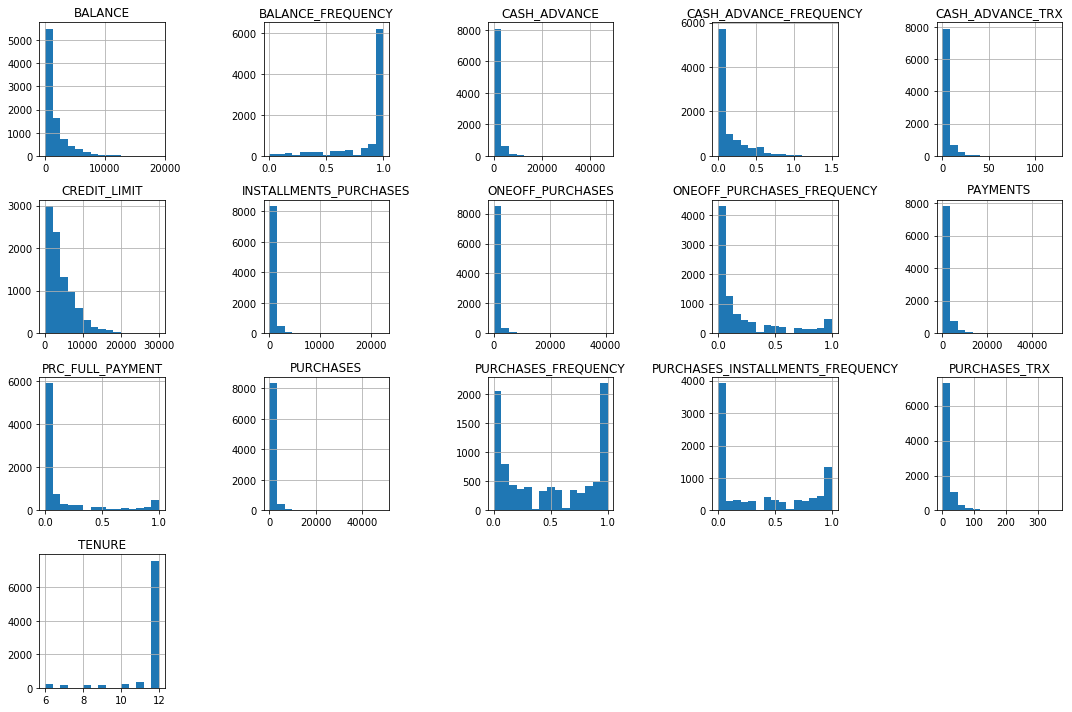

In [7]:
# Generating histograms for each column to understand their distributions
df.hist(bins=15, figsize=(15, 10), layout=(4, 5))
plt.tight_layout()
plt.show()

In [8]:
# filter out CASH_ADVANCE_FREQUENCY > 1
df = df[df['CASH_ADVANCE_FREQUENCY'] <= 1]
# reset indices
df.reset_index(drop=True, inplace=True)

df_transformed = df.copy()

# transformation to address skewness in data
df_transformed.loc[:, df.max(axis=0) > 20] = np.arcsinh(df_transformed.loc[:, df_transformed.max(axis=0) > 20])

print(df_transformed.shape)

(8942, 16)


# Exploratory Data Analysis

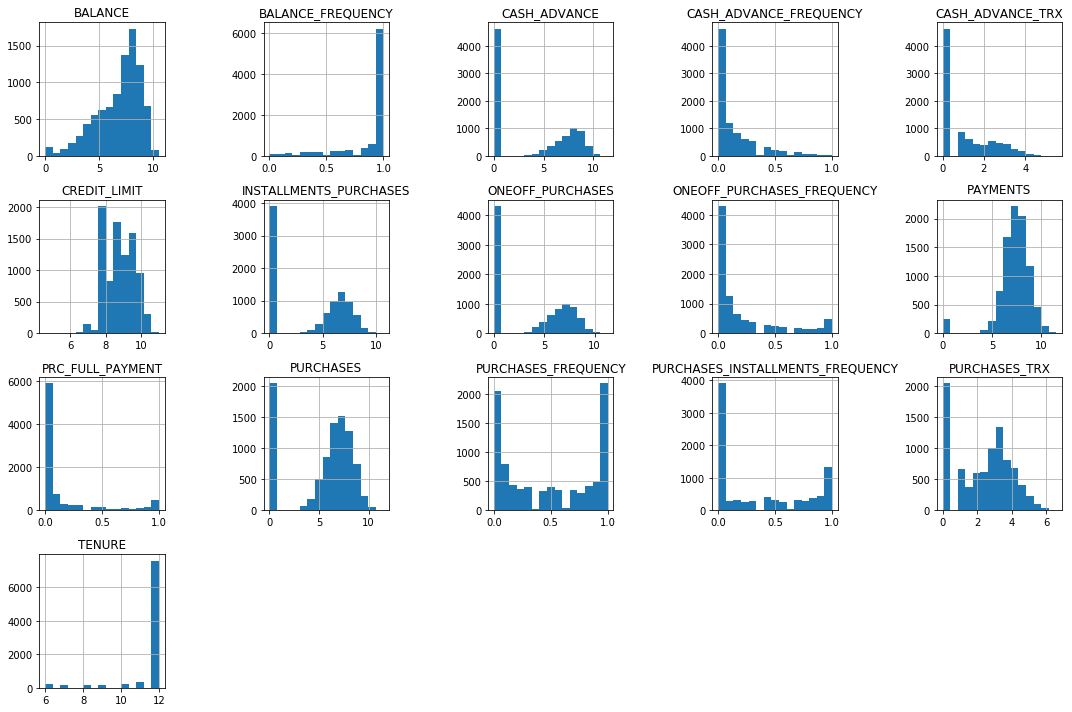

In [9]:
# Generating histograms for each column to understand their distributions
df_transformed.hist(bins=15, figsize=(15, 10), layout=(4, 5))
plt.tight_layout()
plt.show()

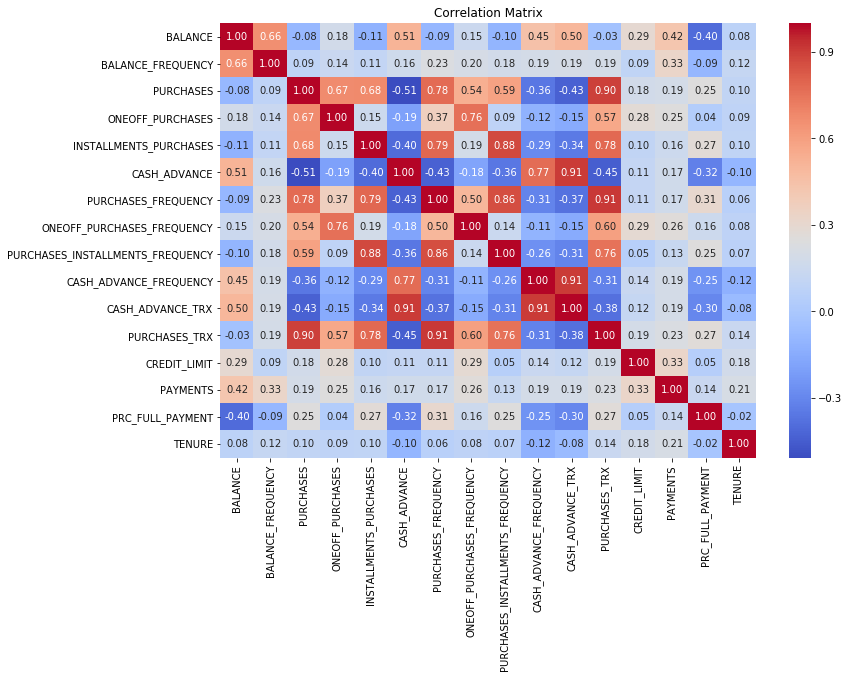

In [10]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df_transformed.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# PCA for visualization

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_transformed)

In [13]:
# Applying PCA for 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Visualization in 2D
fig = px.scatter(pca_df, x='PC1', y='PC2', title="PCA Results in 2D", width=600, height=600)
fig.show()

# Determine number of clusters

## Kmeans

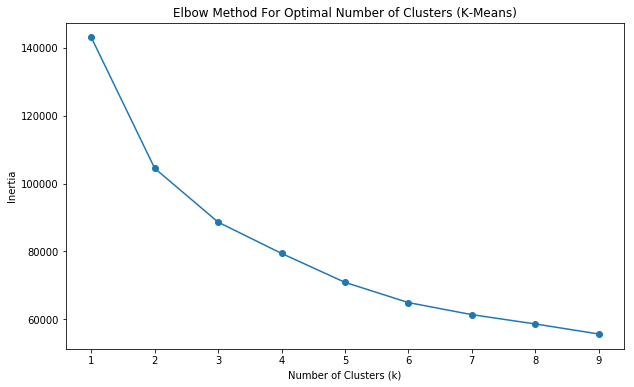

In [14]:
from sklearn.cluster import KMeans

k_values = range(1, 10)

inertia_scores = []

# Calculate K-Means for each k and store inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_data)
    inertia_scores.append(kmeans.inertia_)

# Calculate differences in inertia
inertia_differences = [inertia_scores[i] - inertia_scores[i - 1] for i in range(1, len(inertia_scores))]

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_scores, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

Choose 5 for Kmeans

## Spectral Clustering

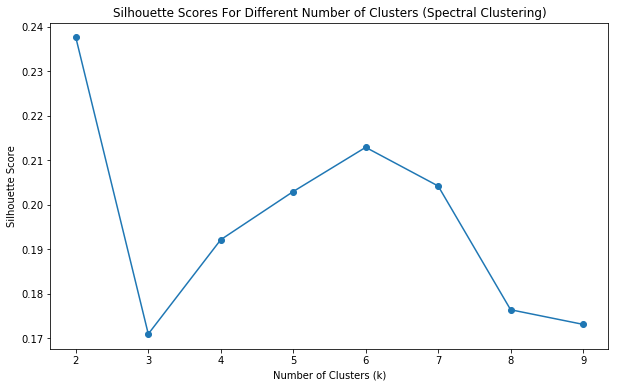

In [15]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score


k_values = range(2, 10)  # Silhouette score is not defined for k=1

# To store the silhouette scores
silhouette_scores = []

# Calculate Spectral Clustering for each k and store silhouette score
for k in k_values:
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    labels = spectral.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)


# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores For Different Number of Clusters (Spectral Clustering)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

Choose 6 for Spectral Clustering

# GMM

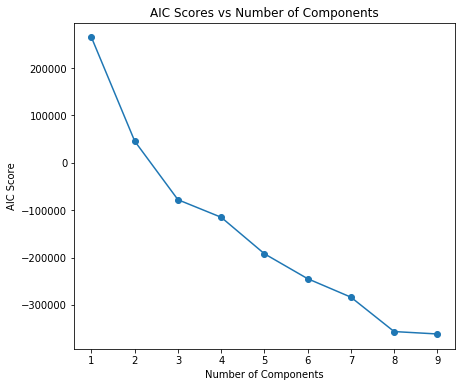

In [16]:
from sklearn.mixture import GaussianMixture

n_components_range = range(1, 10)

# To store the AIC values
aic_scores = []

# Calculate GMM for each number of clusters and store AIC
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(scaled_data)
    aic_scores.append(gmm.aic(scaled_data))


# Plotting the AIC scores
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_scores, marker='o')
plt.title('AIC Scores vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')

plt.show()


Choose 8 for GMM

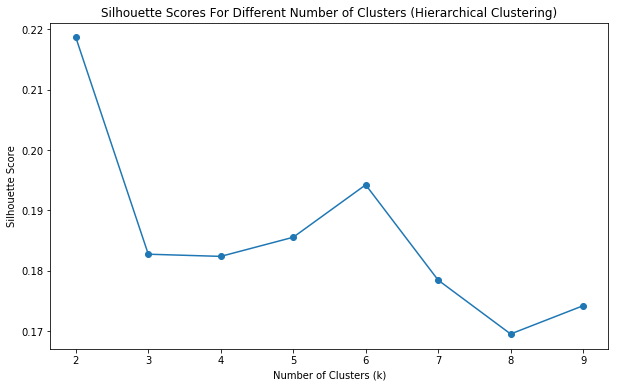

In [17]:
from sklearn.cluster import AgglomerativeClustering

k_values = range(2, 10)  # Silhouette score is not defined for k=1

# To store the silhouette scores
silhouette_scores = []

# Calculate Hierarchical Clustering for each k and store silhouette score
for k in k_values:
    hierarchical = AgglomerativeClustering(n_clusters=k)
    labels = hierarchical.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)


# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores For Different Number of Clusters (Hierarchical Clustering)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


Choose 6 for hierarchical clustering

# Apply Clustering

In [18]:
# Using KMeans for clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(scaled_data)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
visualization_df['Cluster'] = clusters_kmeans

# Create a scatter plot
fig = px.scatter(visualization_df, x='PC1', y='PC2', color='Cluster', title="KMeans Clustering Results" ,width=600, height=600)
fig.show()

In [19]:
# Using Spectral CLustering for clustering
spectral_clustering = SpectralClustering(n_clusters = 6, affinity='nearest_neighbors', random_state=42)
clusters_spectral = spectral_clustering.fit_predict(scaled_data)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
visualization_df['Cluster'] = clusters_spectral

# Create a scatter plot
fig = px.scatter(visualization_df, x='PC1', y='PC2', color='Cluster', title="Spectral Clustering Results", width=600, height=600)
fig.show()


In [20]:
# Use Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_components=8, random_state=42)
clusters_gmm = gmm.fit_predict(scaled_data)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
visualization_df['Cluster'] = clusters_gmm

# Create a scatter plot
fig = px.scatter(visualization_df, x='PC1', y='PC2', color='Cluster', title="GMM Clustering Results", width=600, height=600)
fig.show()


In [21]:
# Use Hierarchical Clustering for clustering
hierarchical = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
clusters_hierarchical = hierarchical.fit_predict(scaled_data)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
visualization_df['Cluster'] = clusters_hierarchical

# Create a scatter plot
fig = px.scatter(visualization_df, x='PC1', y='PC2', color='Cluster', title="Hierarchical Clustering Results", width=600, height=600)
fig.show()


# Cluster Analysis

## PCA for selecting the important factors

In [22]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA components
components_df = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(len(df.columns))])

# Show the DataFrame
components_df

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
PC1   0.091556           0.117329   0.411823          0.346732   
PC2   0.398696           0.131660   0.054248          0.077505   
PC3  -0.115400          -0.425489   0.261923          0.392603   
PC4  -0.281099          -0.374540   0.016867         -0.054102   
PC5   0.080030          -0.305448  -0.089942         -0.245432   
PC6   0.152392          -0.131514   0.197397          0.024879   
PC7  -0.361858           0.171018   0.157836          0.158917   
PC8   0.102723           0.654492   0.101945          0.053616   
PC9   0.034074          -0.079663   0.050173         -0.177300   
PC10  0.165073          -0.126879   0.199467          0.448822   
PC11 -0.570202           0.151251   0.072867         -0.034045   
PC12  0.420630          -0.173283   0.106293         -0.035310   
PC13  0.136438          -0.027592  -0.232750         -0.227397   
PC14  0.141154           0.056150  -0.046591         -0.045135   
PC15 -0.013940          -0.010727   0.002165         -0.004029   
PC16  0.000057           0.000008  -0.748966          0.581958   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
PC1                 0.336631     -0.030515             0.325206   
PC2                -0.014186      0.447736            -0.185947   
PC3                -0.101919     -0.078927            -0.403766   
PC4                 0.139300      0.236017             0.095796   
PC5                 0.238248      0.128260            -0.065017   
PC6                 0.421043     -0.101191            -0.151021   
PC7                 0.081298     -0.035068            -0.112786   
PC8                 0.142528     -0.056382            -0.217977   
PC9                 0.444313     -0.356554            -0.251176   
PC10               -0.352884     -0.354493             0.116951   
PC11                0.234827     -0.153720             0.104364   
PC12                0.315905     -0.062630             0.227690   
PC13               -0.132464     -0.626629             0.004482   
PC14               -0.027266     -0.180328            -0.026049   
PC15                0.013377     -0.006151             0.678227   
PC16                0.316819      0.000021            -0.000154   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
PC1                     0.296833                          0.277509   
PC2                    -0.004435                         -0.177230   
PC3                     0.090632                         -0.494919   
PC4                    -0.174200                          0.182228   
PC5                    -0.426116                          0.165711   
PC6                    -0.444486                          0.115110   
PC7                    -0.111251                         -0.038188   
PC8                    -0.349817                         -0.119581   
PC9                     0.112759                         -0.255235   
PC10                   -0.370018                          0.282664   
PC11                    0.068680                          0.015257   
PC12                    0.294534                         -0.060350   
PC13                    0.037503                          0.033910   
PC14                   -0.026647                         -0.073066   
PC15                   -0.340891                         -0.633680   
PC16                    0.000138                          0.000168   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
PC1                -0.095722         -0.054992       0.391358      0.208277   
PC2                 0.442466          0.428324      -0.010273      0.247839   
PC3                -0.170506         -0.184624      -0.082677      0.105568   
PC4                 0.168122          0.242664      -0.003912     -0.139567   
PC5                -0.165838         -0.064012      -0.077116      0.304029   
PC6                -0.043757         -0.130552       0.115244     -0.192051   


In [23]:
#assume we chose the best clustering and apply it to label the original and transformed data
df['Cluster'] = clusters_spectral
df_transformed['Cluster'] = clusters_spectral
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  PRC_FULL_PAYMENT  TENURE  Cluster  
0   201.802084          0.000000      12        4  
1  4103.032597          0.222222      12        2  
2   622.066742          0.000000      12        3  
3     0.000000          0.000000      12        5  
4   678.334763          0.000000      12        3

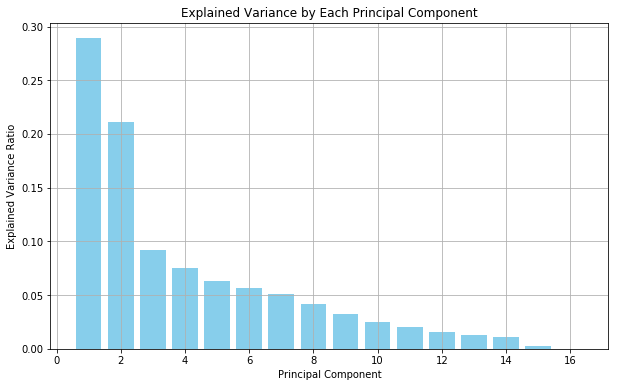

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, color='skyblue')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

## EDA for clusters

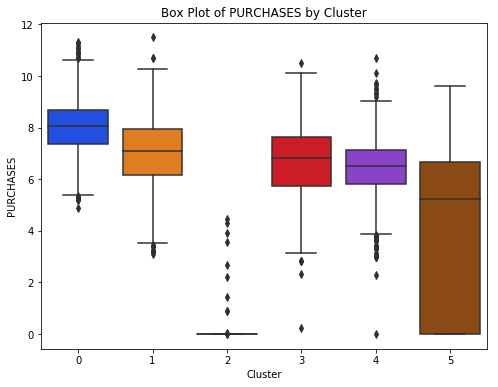

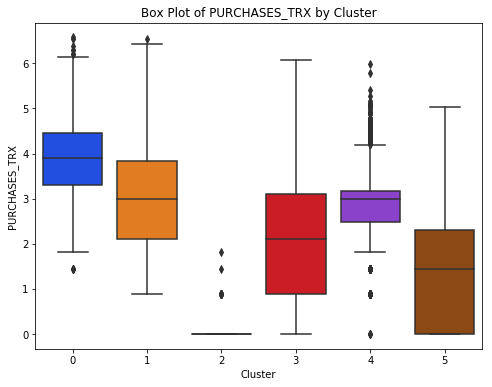

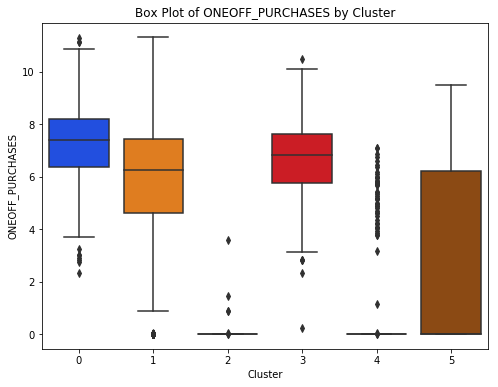

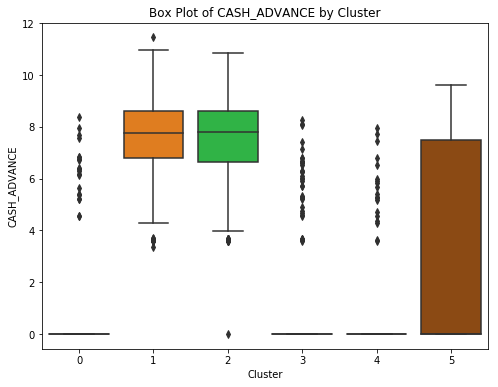

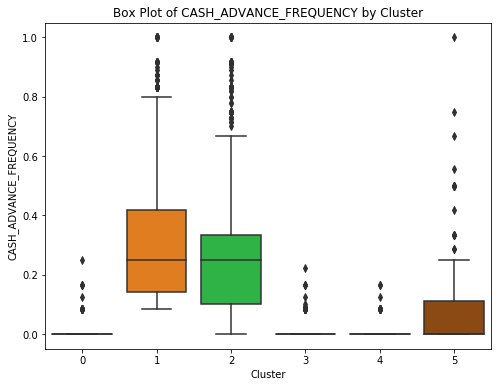

In [25]:
# Strong contrasting colors for clusters
palette = sns.color_palette("bright")

# Function to plot box plot for a given variable
def plot_box(var, palette):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_transformed, x='Cluster', y=var, palette=palette)
    plt.title(f'Box Plot of {var} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(var)
    plt.show()

# Top 5 important variables
top_5_vars = ['PURCHASES', 'PURCHASES_TRX', 'ONEOFF_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY']

# Creating box plots for each of the top 5 variables from pca result
for var in top_5_vars:
    plot_box(var, palette)
